In [1]:
import numpy as np
import torch
import pickle
import time
import os
%matplotlib inline
import matplotlib.pyplot as plt

# Convert to DGL format and save with pickle

In [2]:
import os
os.chdir('../../') # go to root folder of the project
print(os.getcwd())

/home/zsy123/benchmarking-gnns-master


In [3]:
import pickle

%load_ext autoreload
%autoreload 2

from data.molecules import MoleculeDatasetDGL 

from data.data import LoadData
from torch.utils.data import DataLoader
from data.molecules import MoleculeDataset
from dgllife.utils import BaseAtomFeaturizer,WeaveAtomFeaturizer, CanonicalBondFeaturizer, smiles_to_bigraph, EarlyStopping

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/zsy123/benchmarking-gnns-master/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/zsy123/benchmarking-gnns-master/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a depende

In [4]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

In [5]:
df = pd.read_csv('/home/zsy123/benchmarking-gnns-master/data/molecules/Sider/sider.csv')

In [ ]:
import pandas as pd
from rdkit import Chem
from collections import defaultdict

# 用于存储所有不同原子类型和键类型的集合
atom_types = set()
bond_types = set()
df = pd.read_csv('/home/zsy123/benchmarking-gnns-master/data/molecules/Sider/sider.csv')

# 解析每个分子的 SMILES 字符串
for smiles in df['smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # 收集原子类型
        atom_types.update([atom.GetSymbol() for atom in mol.GetAtoms()])
        # 收集键类型
        bond_types.update([bond.GetBondType() for bond in mol.GetBonds()])

# 输出统计结果
print("Unique atom types:", atom_types)
print("Unique bond types:", bond_types)

num_atom_type = len(atom_types)
num_bond_type = len(bond_types)
print(num_atom_type)
print(num_bond_type)

Unique atom types: {'F', 'Na', 'I', 'Sr', 'Cr', 'Se', 'Zn', 'Br', 'C', 'La', 'Y', 'Fe', 'Cf', 'H', 'Ca', 'Ra', 'K', 'Ag', 'Pt', 'Li', 'Mg', 'Ga', 'Gd', 'Ba', 'Cl', 'B', 'Sm', 'Ge', 'Co', 'In', 'Tc', 'Mn', 'As', 'S', 'N', 'P', 'O', 'Cu', 'Tl', 'Au'}
Unique bond types: {rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.TRIPLE, rdkit.Chem.rdchem.BondType.AROMATIC}
40
4


In [6]:
DATASET_NAME = 'Sider'
dataset = MoleculeDatasetDGL(DATASET_NAME) 

Time taken: 74.1824s


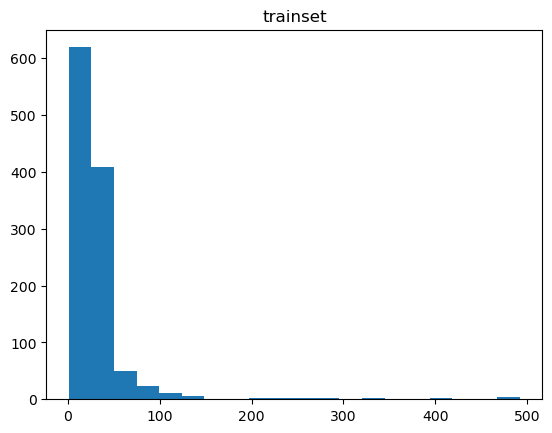

min/max : 1 492


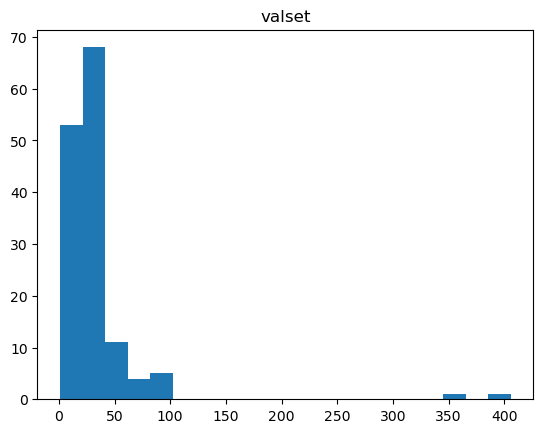

min/max : 1 406


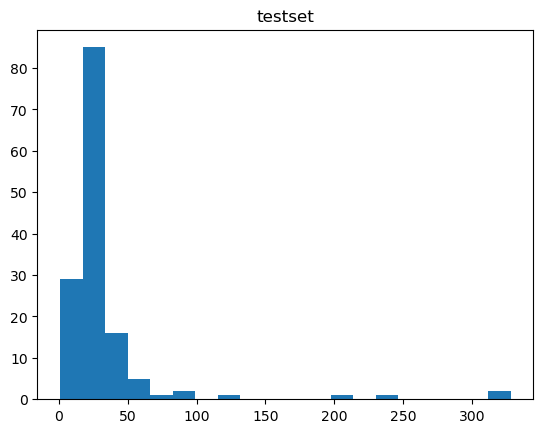

min/max : 1 328


In [ ]:
def plot_histo_graphs(dataset, title):
    # histogram of graph sizes
    graph_sizes = []
    for graph in dataset:
        graph_sizes.append(graph[0].number_of_nodes())
    plt.figure(1)
    plt.hist(graph_sizes, bins=20)
    plt.title(title)
    plt.show()
    graph_sizes = torch.Tensor(graph_sizes)
    print('min/max :',graph_sizes.min().long().item(),graph_sizes.max().long().item())
    
plot_histo_graphs(dataset.train,'trainset')
plot_histo_graphs(dataset.val,'valset')
plot_histo_graphs(dataset.test,'testset')

In [ ]:
print(len(dataset.train))
print(len(dataset.val))
print(len(dataset.test))

print(dataset.train[0])
print(dataset.val[0])
print(dataset.test[0])

print(dataset.train.graph_labels)
print(dataset.val.graph_labels)
print(dataset.test.graph_labels)

print(sum(1 for label in dataset.train.graph_labels if label == 1))
print(sum(1 for label in dataset.val.graph_labels if label == 1))
print(sum(1 for label in dataset.test.graph_labels if label == 1))

1141
143
143
(Graph(num_nodes=91, num_edges=190,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32), 'atom_type': Scheme(shape=(), dtype=torch.int32)}
      edata_schemes={'feat': Scheme(shape=(12,), dtype=torch.float32)}), [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1])
(Graph(num_nodes=23, num_edges=46,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32), 'atom_type': Scheme(shape=(), dtype=torch.int32)}
      edata_schemes={'feat': Scheme(shape=(12,), dtype=torch.float32)}), [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1])
(Graph(num_nodes=15, num_edges=32,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32), 'atom_type': Scheme(shape=(), dtype=torch.int32)}
      edata_schemes={'feat': Scheme(shape=(12,), dtype=torch.float32)}), [1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1])
[[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 

In [ ]:
start = time.time()
with open('/home/zsy123/benchmarking-gnns-master/data/molecules/Sider/sider_8-1-1.pkl','wb') as f:
        pickle.dump([dataset.train,dataset.val,dataset.test,num_atom_type,num_bond_type],f)
print('Time (sec):',time.time() - start)

Time (sec): 0.8292388916015625


In [10]:
DATASET_NAME = 'Sider'
dataset = LoadData(DATASET_NAME, 1)
trainset, valset, testset = dataset.train, dataset.val, dataset.test

[I] 加载数据集 Sider...
[I] 正在加载数据集 Sider...
[I] 数据集 Sider 加载成功
训练集大小: 852, 测试集大小: 284, 验证集大小: 284
[I] 数据加载完成，耗时: 0.8079s
[I] 成功加载数据集: Sider


In [12]:
batch_size = 10
collate = MoleculeDataset.collate
print(MoleculeDataset)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)

<class 'data.molecules.MoleculeDataset'>


In [13]:
def check_and_remove_self_loop(g):
    print("Number of nodes:", g.num_nodes())
    print("Number of edges:", g.num_edges())

    # 检查边特征是否存在
    if 'e' in g.edata:
        print("Edge feature 'e' exists with shape:", g.edata['e'].shape)
    else:
        print("Warning: Edge feature 'e' does not exist.")

    # 检查自环
    self_loops = g.has_self_loop()
    print("Does the graph have self-loops?", self_loops)

    # 尝试移除自环
    try:
        g_no_self_loop = g.remove_self_loop()
        print("Self-loops removed successfully.")
        return g_no_self_loop
    except Exception as e:
        print("Error occurred while removing self-loops:", e)
        return None


In [17]:
for graph,idx in dataset.train:
    # 假设 g 是一个 DGL 图对象
    g_no_self_loop = check_and_remove_self_loop(graph)
    if g_no_self_loop is None:
        print("Self-loop removal failed. Check the graph structure and features.")


Number of nodes: 22
Number of edges: 52


AttributeError: 'DGLHeteroGraph' object has no attribute 'has_self_loop'

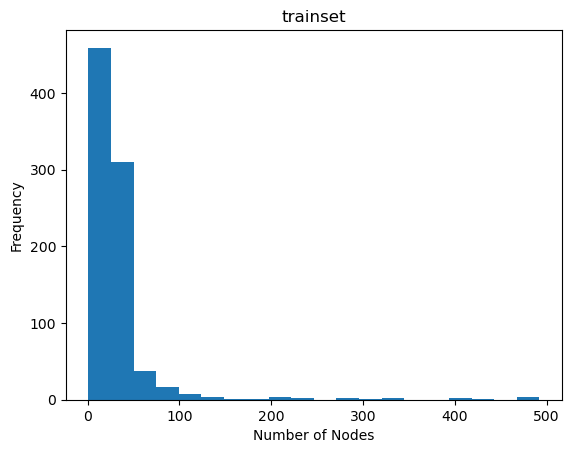

trainset - min/max nodes : 1 / 492
trainset - Number of graphs with self-loops: 852


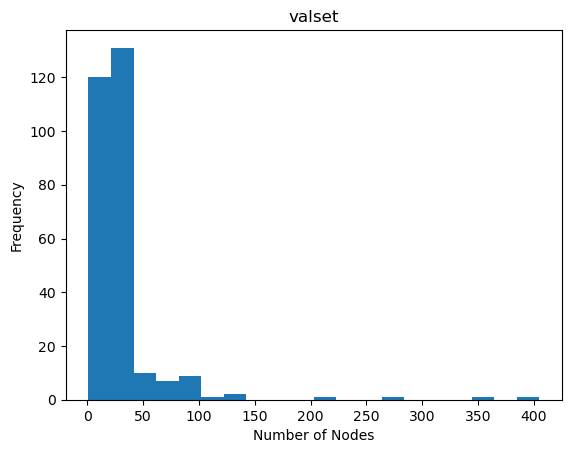

valset - min/max nodes : 1 / 405
valset - Number of graphs with self-loops: 284


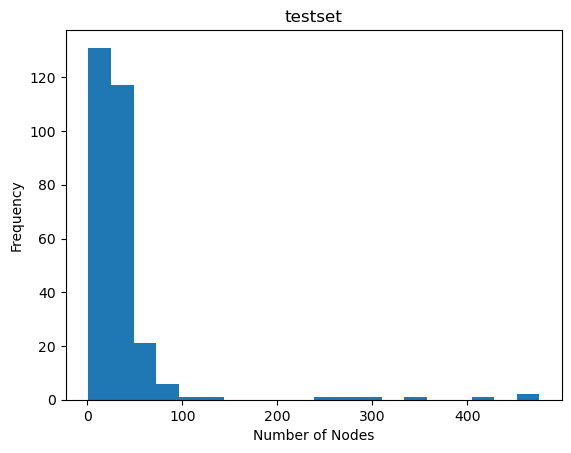

testset - min/max nodes : 1 / 476
testset - Number of graphs with self-loops: 284


In [15]:
import matplotlib.pyplot as plt
import torch

def plot_histo_graphs(dataset, title):
    # 记录图的大小和是否包含自环
    graph_sizes = []
    self_loop_counts = 0
    
    for graph in dataset:
        # 计算图的节点数
        graph_sizes.append(graph[0].number_of_nodes())
        
        # 检查是否包含自环
        if graph[0].remove_self_loop():
            self_loop_counts += 1
    
    # 绘制图节点数的直方图
    plt.figure()
    plt.hist(graph_sizes, bins=20)
    plt.title(title)
    plt.xlabel("Number of Nodes")
    plt.ylabel("Frequency")
    plt.show()
    
    # 转换为 Tensor 并打印最小、最大节点数
    graph_sizes = torch.Tensor(graph_sizes)
    print(f'{title} - min/max nodes : {graph_sizes.min().long().item()} / {graph_sizes.max().long().item()}')
    print(f'{title} - Number of graphs with self-loops:', self_loop_counts)

# 验证训练集、验证集和测试集中的图
plot_histo_graphs(dataset.train, 'trainset')
plot_histo_graphs(dataset.val, 'valset')
plot_histo_graphs(dataset.test, 'testset')
